In [1]:
import sys

sys.path.insert(1, '..')
from functions.other_functions import process_date, process_exposure, chi2, linear
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import time as tm
from scipy.optimize import curve_fit
import xml.dom.minidom as minidom

Welcome to JupyROOT 6.24/02


In [2]:
filename = "/Users/williamquinn/Desktop/PMT_Project/A1400_B1400_t1119.xml"
file = minidom.parse(filename)

In [3]:
traces = file.getElementsByTagName('trace')
print(traces.length)

400000


In [4]:
trace = traces[0]
channel = int(trace.attributes['channel'].value)
print(channel)

0


In [5]:
def get_pulse_par(x, y, baseline):
    x = np.array(x)
    
    pulse_length = len(x)
    amplitude = np.min(y) - baseline;
    position = np.argmin(y)

    start=0
    stop=0
    for i in range(position):
    
        if (y[i]-baseline) < (0.3*amplitude):
            start = i
        if (y[i]-baseline) < (0.7*amplitude):
            stop = i
    
    rise = stop - start
    onset = start

    for i in range(position, pulse_length):
        if (y[i]-baseline) > (amplitude/np.exp(1.0)):
            stop = i;
    fall = stop - position
  
    return onset, rise, fall

def get_baseline(y):
    baseline = 0
    for i in range(100):
        baseline += y[i]
    return baseline/100

def get_amplitude(y, baseline):
    return np.min(y) - baseline

def pulse(x, onset, rise, fall, pos):
    y = []
    for i in range(len(x)):
        if i < onset:
            y.append(0)
        else:
            temp = -np.exp(-(x[i]-pos)/rise) + np.exp(-(x[i]-pos)/fall)
            y.append(temp)
    return y

def gaus(x, A, mu, sig):
    return A*np.exp( -0.5*((x-mu)/sig)**2 )

def bi_fun(x, A, mu, sig):
    return A*(gaus(x,7.08,mu,sig) + gaus(x, 1.84, mu*(1 + 72.144/975.651), sig*1.036) + gaus(x, 0.44, mu*(1 + 84.154/975.651), sig*1.042))

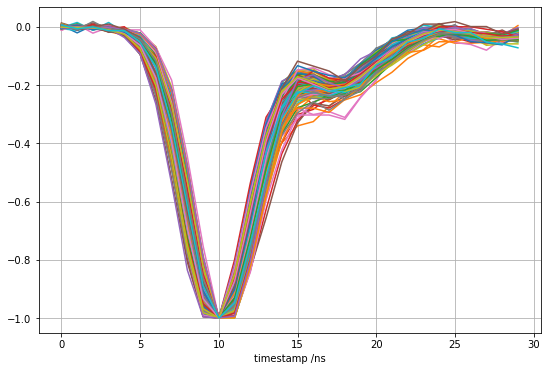

In [6]:
average_waveform = [[],[]]
average_counter = [0,0]
fig = plt.figure(figsize=(9,6), facecolor='white')
for i in range(int(traces.length)):
    trace = traces[i].firstChild.data.split(" ")[:-1]
    channel = int(traces[i].attributes['channel'].value)
    waveform = np.array(trace, dtype='float')
    
    baseline = get_baseline(waveform)
    amplitude = get_amplitude(waveform, baseline)
    
    if average_counter[channel] == 100:
        continue
    
    if amplitude > -100:
        continue
    
    if 0 in waveform:
        continue
    else:
        if len(average_waveform[channel]) == 0:
            average_waveform[channel] = np.zeros_like(waveform[:30])
        else:
            pos = np.argmin(waveform - baseline)
            size = np.min(waveform - baseline)
            if pos > 700:
                continue
            plt.plot(-1*(waveform - baseline)[pos-10:pos+20]/size)
            
            average_counter[channel] += 1
            average_waveform[channel] += -1*(waveform - baseline)[pos-10:pos+20]/size
            
            if average_counter[0] == 100 and average_counter[1] == 100:
                break
            
    if i % 1000 == 0:
        print(i)
        
plt.grid()
plt.xlabel('timestamp /ns')
plt.savefig('/Users/williamquinn/Desktop/pulses.pdf')

In [7]:
templates = []

[-1.00798842 10.11116109  2.21924508]


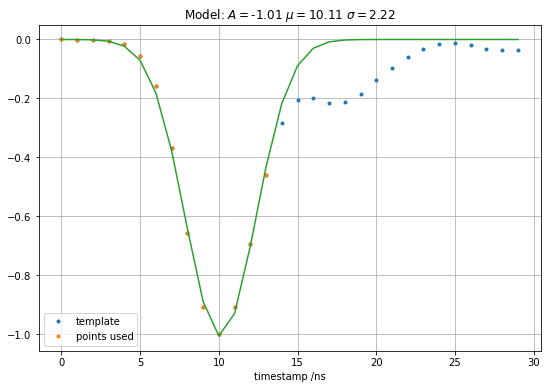

In [8]:
template = average_waveform[0]/average_counter[0]
fig = plt.figure(figsize=(9,6), facecolor='white')
plt.plot(template, ".", label='template')
x = np.array([i for i in range(len(template))])
popt, pcov = curve_fit(f=gaus, xdata=x[:-16], ydata=template[:-16],
                       bounds = [[-1000, 0, 0], [0, 1000, 1000]])
plt.plot(x[:-16], template[:-16], ".", label ='points used' )
A = popt[0]
mu = popt[1]
sig = popt[2]
plt.plot(x,gaus(x,*popt))
print(popt)
plt.xlabel('timestamp /ns')
plt.grid()
plt.title(r'Model: $A=${:.2f} $\mu=${:.2f} $\sigma=${:.2f}'.format(popt[0], popt[1], sig))
plt.legend()
#plt.yscale('log')
plt.savefig('/Users/williamquinn/Desktop/pulse_fit.pdf')
templates.append(template)

In [9]:
print(len(templates[0]))

30


[-1.00702658 10.18354301  2.13877417]


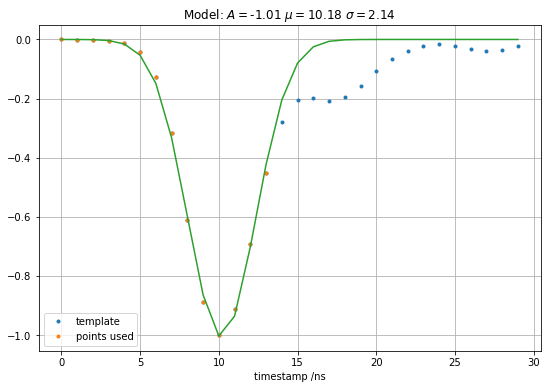

In [10]:
template = average_waveform[1]/average_counter[1]
fig = plt.figure(figsize=(9,6), facecolor='white')
plt.plot(template, ".", label='template')
x = np.array([i for i in range(len(template))])
popt, pcov = curve_fit(f=gaus, xdata=x[:-16], ydata=template[:-16],
                       bounds = [[-1000, 0, 0], [0, 1000, 1000]])
plt.plot(x[:-16], template[:-16], ".", label ='points used' )
A = popt[0]
mu = popt[1]
sig = popt[2]
plt.plot(x,gaus(x,*popt))
print(popt)
plt.xlabel('timestamp /ns')
plt.grid()
plt.title(r'Model: $A=${:.2f} $\mu=${:.2f} $\sigma=${:.2f}'.format(popt[0], popt[1], sig))
plt.legend()
#plt.yscale('log')
plt.savefig('/Users/williamquinn/Desktop/pulse_fit.pdf')
templates.append(template)

In [11]:
root_file = ROOT.TFile("/Users/williamquinn/Desktop/PMT_Project/1400V_pulse_30ns.root", "RECREATE")
av_hist0 = ROOT.TH1D("1400V_pulse_30ns_Ch0", "1400V_pulse_30ns_Ch0",
                    len(template), 0, len(template))
av_hist1 = ROOT.TH1D("1400V_pulse_30ns_Ch1", "1400V_pulse_30ns_Ch1",
                    len(template), 0, len(template))
for i in range(len(templates[0])):
    av_hist0.SetBinContent(i+1, templates[0][i])
    av_hist1.SetBinContent(i+1, templates[1][i])
    
root_file.cd()
av_hist0.Write()
av_hist1.Write()
root_file.Close()

In [12]:
def gaus_fix_sig(x, A, mu):
    return A*np.exp( -0.5*((x-mu)/2.21924508)**2 )

In [13]:
counter = 0
fit_counter = 0
charges = []
ap_charges = []
for i in range(int(traces.length)):
    trace = traces[i].firstChild.data.split(" ")[:-1]
    channel = int(traces[i].attributes['channel'].value)
    if channel == 1:
        continue
    waveform = np.array(trace, dtype='float')
    
    baseline = get_baseline(waveform)
    amplitude = get_amplitude(waveform, baseline)
    
    if i % 10000 == 0:
        print(i)
    
    if amplitude > -50:
        continue
        
    if 0 in waveform:
        pass
    else:
        charge = np.sum((waveform - baseline)[pos-10:pos+20])/50
        ap_charge = np.sum((waveform - baseline)[800:])/50
        charges.append(charge)
        ap_charges.append(ap_charge)
        continue
    
    # pos = np.argmin(waveform - baseline)
    pos = np.where( waveform==0 )[0]
    
    middle = int(len(pos) / 2) # = int(2.5) = 2
    pos=pos[middle] # 3
    size = np.min(waveform - baseline)
    
    waveform_r = (waveform - baseline)[pos-10:pos+20]
    pulse = waveform[pos-10:pos+20]
    
    '''fig = plt.figure(figsize=(9,6), facecolor='white')
    plt.plot([k for k in range(len(waveform_r))], waveform_r, '.', label='pmt pulse')
    # plt.plot([k for k in range(len(waveform_r))], template*-1*size *1.7, '.')
    plt.xlabel('timestamp /ns')
    plt.ylabel('Voltage /mV')'''
    
    fit_counter += 1
    shapes = []
    # sizes = np.linspace(0,5,5000)
    sizes = [1]
    
    new_pulse = []
    xi = []
    for j in range(len(pulse)):
        if j > 14:
            break
        if pulse[j] == 0:
            continue
        else:
            new_pulse.append(waveform_r[j])
            xi.append(j)
            
    popt, pcov = curve_fit(f=gaus_fix_sig, xdata=np.array(xi), ydata=new_pulse, bounds=[[-10000, 0], [0, 40]])
    
    '''plt.plot([k for k in range(len(waveform_r))], -1*template*popt[0], '.', label='scaled template')
    plt.plot([k for k in range(len(waveform_r)-15)], gaus_fix_sig([k for k in range(len(waveform_r)-15)], *popt), label='model')
    plt.plot(xi, new_pulse, '.', label='model points')
    print(xi, popt)
    plt.legend()
    plt.grid()
    plt.title(r'Model: $A=${:.2f} $\mu=${:.2f} $\sigma=${:.2f}'.format(popt[0], popt[1], sig))
    plt.savefig("/Users/williamquinn/Desktop/fit_plot_{}.pdf".format(fit_counter))
    plt.close()'''
    
    new_temp = -1*template*popt[0]
    charge = np.sum(new_temp)/50
    
    
    charges.append(charge)
    ap_charge = np.sum((waveform - baseline)[800:])/50
    ap_charges.append(ap_charge)
    
    '''sizes = np.linspace(0,5000,5000)
    for i_size in sizes:
        test = []
        temp = []
        for j in range(len(waveform_r)):
            if pulse[j] == 0:
                continue
            else:
                temp.append(template[j])
                test.append(waveform_r[j])
                
            if j > 14:
                break
        test=np.array(test)
        temp=np.array(temp)
        shapes.append(np.sum((temp*-1*i_size - test)/(temp*-1*i_size)))
        #shape = np.dot(test, temp*-1*i_size)
        #shapes.append(shape)
    #amp = sizes[np.argmin(shapes)]
    #print(amp)'''
    
    '''if fit_counter == 10:
        break'''
    

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000


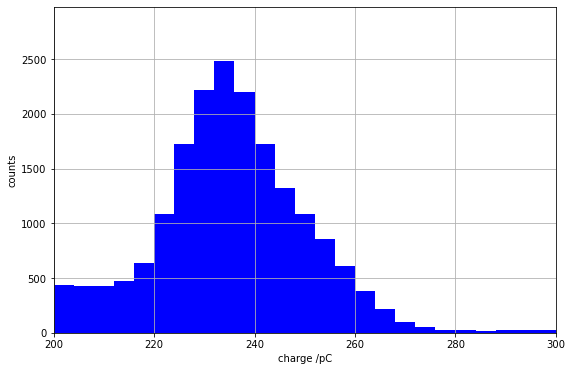

In [14]:
fig = plt.figure(figsize=(9,6), facecolor='white')
freq, bin_edges = np.histogram(-1*np.array(charges), 100, range=(0,400))
width = bin_edges[-1] - bin_edges[-2]
bin_centres = bin_edges[:-1] + width/2
plt.bar(bin_centres, freq, width=width, color="blue")
plt.xlabel('charge /pC')
plt.ylabel('counts')
plt.grid()
plt.xlim(200,300)
plt.savefig("/Users/williamquinn/Desktop/1400V_bi207_charge_spec.pdf")

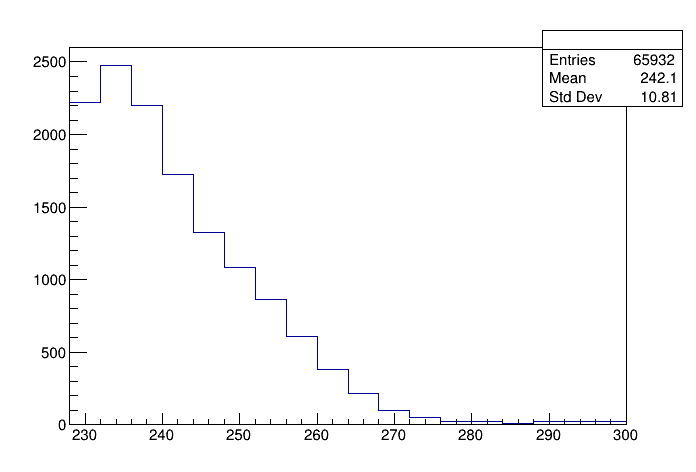

In [15]:
lower, higher = 230, 300
hist = ROOT.TH1D("","", 100, 0, 400)

for i in range(len(charges)):
    hist.Fill(-1*charges[i])
    
can = ROOT.TCanvas()
hist.GetXaxis().SetRangeUser(lower, higher)
hist.Draw("hist")
can.Draw()

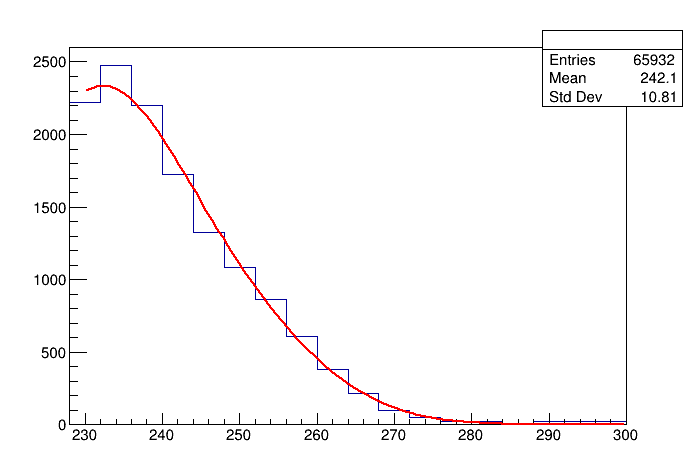

In [16]:
bismuth_func_string_0 = "[0]*(7.08*TMath::Gaus(x,[1],[2]) + 1.84*TMath::Gaus(x,[1]*(1 + 72.144/975.651),[2]*1.036) + 0.44*TMath::Gaus(x,[1]*(1 + 84.154/975.651),[2]*1.042))"

fit = ROOT.TF1("fit", bismuth_func_string_0, lower, higher)
fit.SetParameters(1000, 260, 10)

hist.Fit("fit", "0Q", "", lower, higher)
can = ROOT.TCanvas()
hist.GetXaxis().SetRangeUser(lower, higher)
hist.Draw("hist")
fit.Draw("same")
can.Draw()

In [17]:
names = ['A','mu','sig']
popt= []
perr= []
for i in range(3):
    print(names[i], fit.GetParameter(i), '±', fit.GetParError(i))
    popt.append(fit.GetParameter(i))
    perr.append(fit.GetParError(i))
chi = fit.GetChisquare() / fit.GetNDF()
print(r'$\chi_R^2$', fit.GetChisquare() / fit.GetNDF())

A 296.0443439423991 ± 4.844444339688709
mu 230.52752246260914 ± 0.8815083707769549
sig 11.073243476436664 ± 0.6163834014551514
$\chi_R^2$ 7.9980251726631195


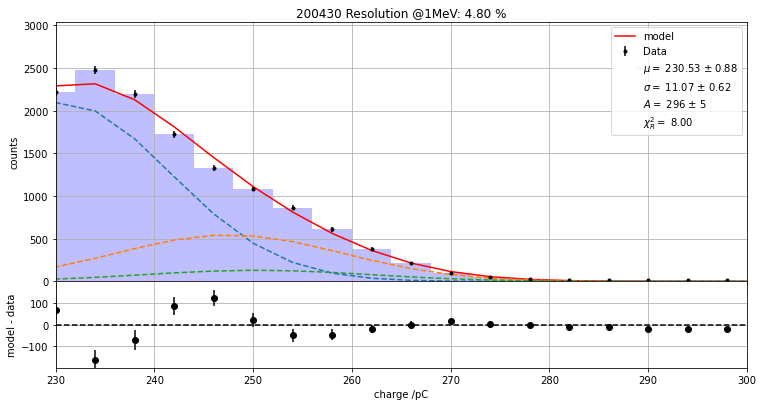

In [18]:
#PLOT
date = '200430'
mu = popt[1]
mu_err = perr[1]
A = popt[0]
A_err = perr[0]
sig = popt[2]
sig_err = perr[2]
fig1 = plt.figure(figsize=(12,6), facecolor='white')
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.bar(bin_centres, freq, width = width, color='b', alpha=0.25)
plt.errorbar(bin_centres, freq, yerr=np.sqrt(freq), fmt='k.', label = 'Data')
plt.plot(bin_centres,
         bi_fun(x=bin_centres, mu=mu, sig=sig, A=A), 'r-',
         label = 'model')
plt.plot(bin_centres, gaus(x= bin_centres, mu=mu, sig=sig, A=A*7.08), '--')
plt.plot(bin_centres, gaus(x=bin_centres, mu=mu*(1 + 72.144/975.651), sig=sig*1.036, A=A*1.84), '--')
plt.plot(bin_centres, gaus(x=bin_centres, mu=mu*(1 + 84.154/975.651), sig=sig*1.042, A=A*0.44), '--')
plt.grid()
frame1.set_xticklabels([])

handles, labels = plt.gca().get_legend_handles_labels()
patch = matplotlib.patches.Patch(color='white', label=r'$\mu =$ {:.2f} ± {:.2f}'.format(mu, mu_err))
patch_1 = matplotlib.patches.Patch(color='white', label=r'$\sigma =$ {:.2f} ± {:.2f}'.format(sig, sig_err)) 
patch_2 = matplotlib.patches.Patch(color='white', label=r'$A =$ {:.0f} ± {:.0f}'.format(A, A_err)) 
patch_3 = matplotlib.patches.Patch(color='white', label=r'$\chi^2_R =$ {:.2f}'.format(chi)) 
handles.extend([patch, patch_1, patch_2, patch_3])
plt.legend(handles=handles, loc='upper right')


plt.ylabel('counts')
plt.xlim(lower, higher)
plt.title(date+' Resolution @1MeV: {:.2f} %'.format(sig/mu * 100))
plt.xlim(lower, higher)

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))        
plt.errorbar(bin_centres,
             bi_fun(x=bin_centres,mu=mu, sig=sig, A=A) - freq,
             yerr= np.sqrt(freq), fmt='ko')
plt.grid()
plt.xlim(lower, higher)
plt.xlabel('charge /pC')
plt.ylabel('model - data')
plt.axhline(0,ls = '--', color='black')
plt.xlim(lower, higher)
plt.ylim(-199,199)
plt.savefig("/Users/williamquinn/Desktop/1400V_bi207_charge_spec_fit.pdf")

In [19]:
e = 1.602e-19
r = 9.68/244.03
print(r)
npe = (2.355/r)**2
print(npe)
ne = 244.03 * 1e-12/e
print(ne)
print(ne/npe)

0.03966725402614432
3524.662582787875
1523283395.7553058
432178.5021902568


/var/folders/z0/ktldz45s5hn1fwbvyy8qxzdh0000gn/T/ipykernel_10251/2407000051.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  charge_hist.Fill(-1*ap_charges[i]/(-1*charges[i]))


 FCN=1356.87 FROM MIGRAD    STATUS=CONVERGED     256 CALLS         257 TOTAL
                     EDM=3.41395e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.72712e+03   3.43185e+01   4.94514e-02   2.71203e-05
   2  p1           8.63327e-02   5.55303e-04   1.68631e-06   3.23290e+00
   3  p2           8.49953e-02   4.58399e-04  -1.33897e-06   1.28164e-01
   4  p3          -2.77255e-01   1.06346e-01  -1.20941e-03   2.91295e-03


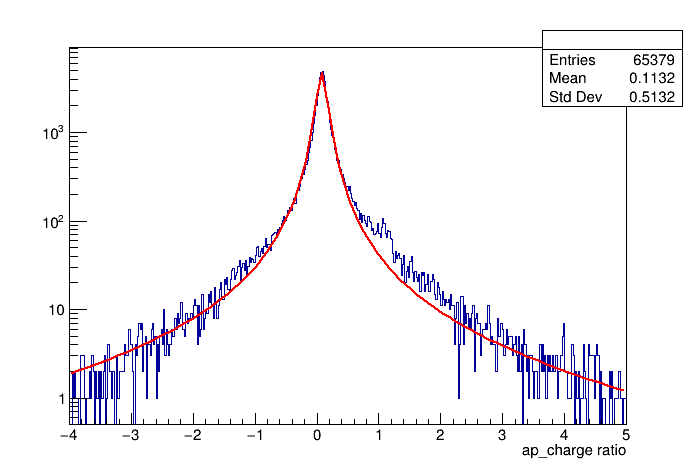

In [20]:
hist_2d = ROOT.TH2D("", "", 100, 0, 400, 20, 0, 100)

upper = 5
lower = -4
n_bins = (upper - lower)*50

charge_hist = ROOT.TH1D("", "", n_bins, lower, upper)
charge_hist.GetXaxis().SetTitle("ap_charge ratio")
fit_ = ROOT.TF1("fit_", "[0]*([1]**2/((x - [2])**2 + [1]**2)) + [3]", lower, upper)
for i in range(len(charges)):
    #print(charges[i], ap_charges[i])
    if -1*charges[i] < 0:
        continue
        
    '''if -1*ap_charges[i] < 0:
        continue'''
    charge_hist.Fill(-1*ap_charges[i]/(-1*charges[i]))
    
    hist_2d.Fill(-1*charges[i], -1*ap_charges[i])
fit_.SetParameters(1000, 1, 0.1, 1)
charge_hist.Fit("fit_", "S", "", lower, upper)

can = ROOT.TCanvas()
can.cd()
charge_hist.Draw("HIST")
fit_.Draw("SAME")
can.SetLogy()
can.Draw()


[-10.5256   9.168   33.6536 ...   2.708    5.8128  -3.7248]


Text(0.5, 0, 'charge /pC')

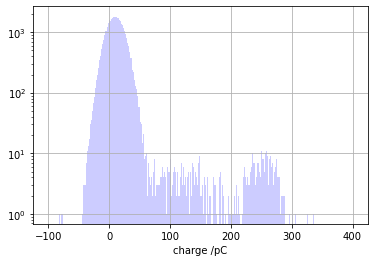

In [23]:
print(np.array(ap_charges)*-1)
freq, bin_edges = np.histogram(np.array(ap_charges)*-1, 500, range=(-100, 400))
width = bin_edges[-1] - bin_edges[-2]
bin_centres = bin_edges[:-1] + width / 2
plt.bar(bin_centres, freq, color="blue", width=width, label='', alpha=0.2)
#plt.errorbar(bin_centres, freq, yerr=np.sqrt(freq), fmt='k.')
#plt.xlim(-100, 400)
plt.grid()
plt.yscale('log')
plt.xlabel('charge /pC')

/var/folders/z0/ktldz45s5hn1fwbvyy8qxzdh0000gn/T/ipykernel_10251/43745612.py:21: RuntimeWarning: divide by zero encountered in true_divide
  freq, bin_edges = np.histogram(r1/r0, n_bins, range=(lower, upper))


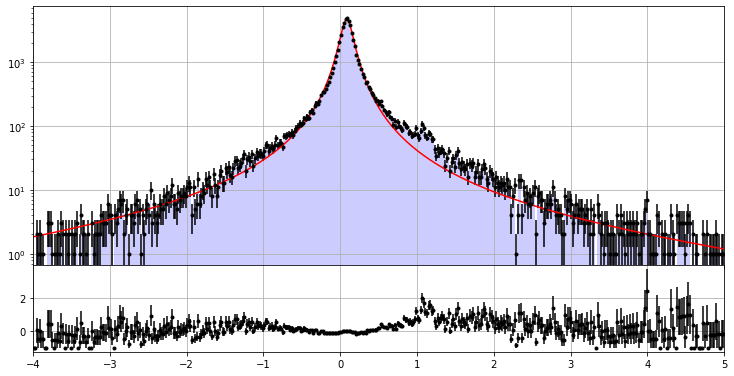

In [22]:
def lorentz(x, p0, p1, p2, p3):
    return p0*(p1**2/((x - p2)**2 + p1**2)) + p3

upper = 5
lower = -4
n_bins = (upper - lower)*50

r0 = []
r1 = []
for i in range(len(charges)):
    if charges[i] > 0:
        continue
    r0.append(-1*charges[i])
    r1.append(-1*ap_charges[i])
r0 = np.array(r0)
r1 = np.array(r1)

fig1 = plt.figure(figsize=(12,6), facecolor='white')
frame1=fig1.add_axes((.1,.3,.8,.6))
frame1.set_xticklabels([])
freq, bin_edges = np.histogram(r1/r0, n_bins, range=(lower, upper))
width = bin_edges[-1] - bin_edges[-2]
bin_centres = bin_edges[:-1] + width / 2
y = lorentz(bin_centres,fit_.GetParameter(0), fit_.GetParameter(1),fit_.GetParameter(2), fit_.GetParameter(3))
# y = lorentz(bin_centres,fit_.GetParameter(0), fit_.GetParameter(1),fit_.GetParameter(2), 0)
plt.bar(bin_centres, freq, color="blue", width=width, label='', alpha=0.2)
plt.errorbar(bin_centres, freq, yerr=np.sqrt(freq), fmt='k.')
plt.plot(bin_centres, y, "-r")
plt.xlim(lower, upper)
plt.grid()
plt.yscale('log')

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.errorbar(bin_centres, (freq - y)/y, yerr=np.sqrt(freq)/y, fmt='k.')
plt.xlim(lower, upper)
plt.grid()

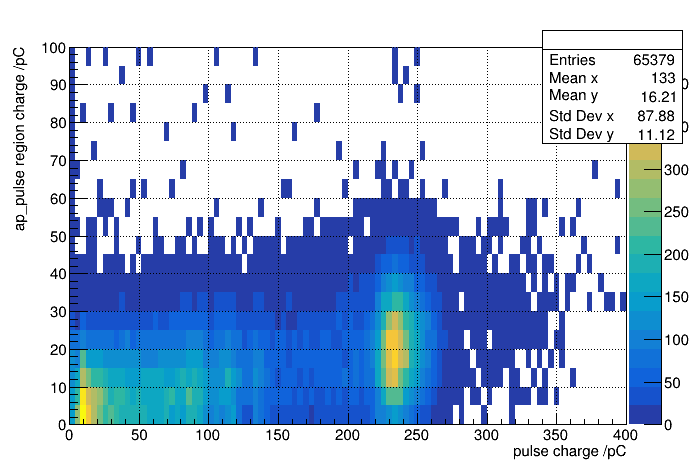

In [24]:
can = ROOT.TCanvas()
hist_2d.Draw('colz')
can.SetGrid()
hist_2d.GetXaxis().SetTitle("pulse charge /pC")
hist_2d.GetYaxis().SetTitle("ap_pulse region charge /pC")
can.Draw()

In [25]:
names = ['A', 'Y', 'mu', 'h']
popt= []
perr= []
for i in range(4):
    print(names[i], fit_.GetParameter(i), '±', fit_.GetParError(i))
    popt.append(fit_.GetParameter(i))
    perr.append(fit_.GetParError(i))
chi = fit_.GetChisquare() / fit_.GetNDF()
print(r'$\chi_R^2$', fit_.GetChisquare() / fit_.GetNDF())

A 4727.118852154741 ± 34.318508085917365
Y 0.08633266275586055 ± 0.0005553029613081453
mu 0.08499534195710232 ± 0.000458398728333705
h -0.27725544102247573 ± 0.1063459072187634
$\chi_R^2$ 3.200158450079128


In [ ]:
file = ROOT.TFile("/Users/williamquinn/Desktop/pmt_short_templates.root", "READ")
file.ls()

In [ ]:
ROOT.gStyle.SetOptStat(0)
short_template = file.Get("Template_Ch0")
short_temp = []
for i in range(1, short_template.GetNbinsX() + 1):
    print(i, short_template.GetBinContent(i))
    short_temp.append(short_template.GetBinContent(i))
can = ROOT.TCanvas()
can.cd()
short_template.Draw()
can.Draw()
short_temp = np.array(short_temp)

In [ ]:
print(len(short_temp))
norm_short_temp = short_temp/np.sqrt(np.dot(short_temp, short_temp))
amp = np.min(norm_short_temp)
print(amp)
plt.plot(10*norm_short_temp /amp * -1)

In [ ]:
35.22803183690809*amp

In [ ]:
file = ROOT.TFile("/Users/williamquinn/Desktop/110011_A1400_B1400_t0127_3.root", "READ")
tree = file.T

for event in tree:
    waveform = event.waveform
    
    plt.plot(waveform)
plt.xlim(1400,2000)
plt.ylim(900,1000)

In [ ]:
fig1 = plt.figure(figsize=(9,6), facecolor='white')
guess = [3.50980737e-11, 2.12469979e-01, 1.71722438e+07, 3.25114206e+07, 4.22330995e+06]
bounds = [[guess[i] - guess[i]/2 for i in range(len(guess))], [guess[i] + guess[i]/2 for i in range(len(guess))]]

popt_0, pcov_0 = curve_fit(f=new_model_0, xdata=x, ydata=y_, p0=guess, bounds=bounds)
#Plot Data-model
new_x = [i for i in range(1000)]
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.errorbar(x, y_, yerr=error_size, fmt='k.', label='Exposed adjusted')
plt.plot(x, new_model_0(x, *popt_0), 'r-', zorder=10, linewidth=2,
         label=r'model 0 $\chi_R=${:.2f}'.format(chi2(y_, error_size, (new_model_0(x, *popt_0)), len(popt_0))))
#plt.plot(x, new_model(x, *popt), 'g-')
#plt.plot(x, model_day(x, *popt), 'r-')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.grid()
plt.ylabel("Average apulse num")
plt.xlim(x[0], x[-1])
plt.legend(loc='upper left')
plt.title("Average apulse num vs exposure time")

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
plt.errorbar(x, new_model_0(x, *popt_0) - y_, yerr=error_size, fmt='r.')
plt.axhline(0,ls='--', color='k')
plt.grid()
plt.xlim(x[0], x[-1])
plt.ylim(-0.25, 0.25)
plt.ylabel("model - data")
plt.xlabel("exposure time relative to 11/02/2020 /days")
plt.tight_layout()
# plt.savefig('/Users/williamquinn/Desktop/model_0.pdf')

In [ ]:
fig1 = plt.figure(figsize=(9,6), facecolor='white')
guess = [3.50980737e-11, 2.12469979e-01, 1.71722438e+07, 3.25114206e+07, 4.22330995e+06]
bounds = [[guess[i] - guess[i]/2 for i in range(len(guess))], [guess[i] + guess[i]/2 for i in range(len(guess))]]

popt_1, pcov_1 = curve_fit(f=new_model_1, xdata=x, ydata=y_, p0=guess, bounds=bounds)
#Plot Data-model
new_x = [i for i in range(1000)]
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.errorbar(x, y_, yerr=error_size, fmt='k.', label='Exposed adjusted')
plt.plot(x, new_model_1(x, *popt_1), 'b-', zorder=5, linewidth=2,
         label=r'model 1 $\chi_R=${:.2f}'.format(chi2(y_, error_size, (new_model_1(x, *popt_1)), len(popt_1))))
#plt.plot(x, new_model(x, *popt), 'g-')
#plt.plot(x, model_day(x, *popt), 'r-')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.grid()
plt.ylabel("Average apulse num")
plt.xlim(x[0], x[-1])
plt.legend(loc='upper left')
plt.title("Average apulse num vs exposure time")

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
plt.errorbar(x, new_model_1(x, *popt_1) - y_, yerr=error_size, fmt='b.')
plt.axhline(0,ls='--', color='k')
plt.grid()
plt.xlim(x[0], x[-1])
plt.ylim(-0.25, 0.25)
plt.ylabel("model - data")
plt.xlabel("exposure time relative to 11/02/2020 /days")
plt.tight_layout()
# plt.savefig('/Users/williamquinn/Desktop/model_1.pdf')

In [ ]:
print(popt_1)
L = popt_1[2]/(3600*24)
print("L:", '{:.2f}'.format(L), "days")
print("D:", '{:.2e}'.format(0.1**2/(popt_1[2]*6)), 'cm^2/s')

In [ ]:
plt.figure(figsize=(9,6), facecolor='white')
fig,ax = plt.subplots()
new_x = [i for i in range(800)]
# plt.errorbar(x, y_, yerr=error_size, fmt='k.', label='Exposed adjusted')
plt.plot(new_x, new_model_1(new_x, *popt_1), 'b-', zorder=5, linewidth=2,
         label=r'model 1 $\chi_R=${:.2f}'.format(chi2(y_, error_size, (new_model_1(x, *popt_1)), len(popt_1))))
plt.plot(new_x, new_model_1_(new_x, popt_1[0], popt_1[1], popt_1[2]))
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.grid()
plt.ylabel("Average apulse num")
#plt.xlim(new_x[0], 400)
plt.ylim(0,np.max(new_model_1_(new_x, popt_1[0], popt_1[1], popt_1[2])))
plt.legend(loc='upper left')
plt.title("Average apulse num vs exposure time")
m = popt_1[0]*101325/10 * 3600*24
c = -1*m*(L + popt_1[1])
plt.plot(new_x, linear(new_x, m, c))
plt.axvline(L, ls='--', color='red')

#ax2 = ax.twinx()
#plt.plot(new_x, eff(new_x, popt_1[-2], popt_1[-1]))

In [ ]:
m = (1e6 - 2e5)/(1460 - 1110)
c = 1e6 - m*1460

plt.plot(np.linspace(0,2000,2), m*np.linspace(0,2000,2) + c)
plt.xlim(750,1500)
plt.grid()
print(m*1400 + c)
print(m*1000 + c)

In [ ]:
t0 = 590e-9
Z = 1
e = 1.6
m = 6.6464731
d = 0.1
V = 1000
tau = (np.pi/2) * np.sqrt(1e-8*(m*(d**2))/(2*Z*e*V))
print(tau*1e6)

print((tau + t0)*1e6)
print((tau + tau + t0)*1e6)